<a href="https://colab.research.google.com/github/Jvlia17/rodents-classification/blob/main/Rosegador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ten kod jest poświęcony kodowaniu w ramach pracy magisterskiej skupionej na opracowywaniu niestandardowego zestawu danych do rozpoznawania gryzoni przy użyciu sztucznej inteligencji. W jego ramach wykorzystuje się najnowocześniejsze technologie, różnorodne metody bilansowania danych, dostrojenie hiperparametrów, transfer learning oraz ataki adwersarialne na sieci w celu poprawy odporności i efektywności modelu.

Github: https://github.com/Jvlia17/rodents-classification

# 0. Pobranie bibliotek

In [ ]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
sns.set_style('darkgrid')

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-03-07 16:07:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-03-07 16:07:29 (70.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# 1. Pobranie danych

In [ ]:
# Usuwanie istniejących folderów
!rm -rf sample_data

# Pobranie danych i wyodrębnienie ich
!wget https://www.dropbox.com/scl/fi/xhgs04km1gn53ebccmjjy/Rosegador.zip?rlkey=pkbd9d125ebb4untz49lv872p&dl=0

--2024-03-07 16:07:32--  https://www.dropbox.com/scl/fi/xhgs04km1gn53ebccmjjy/Rosegador.zip?rlkey=pkbd9d125ebb4untz49lv872p
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucab66bc2ca1329c3e9b76caed58.dl.dropboxusercontent.com/cd/0/inline/COqNnUWfN1X1fFPEYhHwK7TIK86QuMmC0BN7DCGZYMXJgP9OZBkpyuZzyZo1x9QhppxGp2-ec1-_t266O5-A9LJWCtEfkAnegTAy15I_kd1DMauorfgLz1ml3Oe2hlorYtCqYvl17cx4JGohz7r30kr0/file# [following]
--2024-03-07 16:07:33--  https://ucab66bc2ca1329c3e9b76caed58.dl.dropboxusercontent.com/cd/0/inline/COqNnUWfN1X1fFPEYhHwK7TIK86QuMmC0BN7DCGZYMXJgP9OZBkpyuZzyZo1x9QhppxGp2-ec1-_t266O5-A9LJWCtEfkAnegTAy15I_kd1DMauorfgLz1ml3Oe2hlorYtCqYvl17cx4JGohz7r30kr0/file
Resolving ucab66bc2ca1329c3e9b76caed58.dl.dropboxusercontent.com (ucab66bc2ca1329c3e9b76caed58.dl.dropboxusercontent.com)... 162.125.5.15, 2620:

In [ ]:
!unzip /content/Rosegador.zip?rlkey=pkbd9d125ebb4untz49lv872p

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Capybara/cap (4260).jpg  
  inflating: Dataset/Capybara/cap (4261).jpg  
  inflating: Dataset/Capybara/cap (4262).jpg  
  inflating: Dataset/Capybara/cap (4263).jpg  
  inflating: Dataset/Capybara/cap (4264).jpg  
  inflating: Dataset/Capybara/cap (4265).jpg  
  inflating: Dataset/Capybara/cap (4266).jpg  
  inflating: Dataset/Capybara/cap (4267).jpg  
  inflating: Dataset/Capybara/cap (4268).jpg  
  inflating: Dataset/Capybara/cap (4269).jpg  
  inflating: Dataset/Capybara/cap (427).jpg  
  inflating: Dataset/Capybara/cap (4270).jpg  
  inflating: Dataset/Capybara/cap (4271).jpg  
  inflating: Dataset/Capybara/cap (4272).jpg  
  inflating: Dataset/Capybara/cap (4273).jpg  
  inflating: Dataset/Capybara/cap (4274).jpg  
  inflating: Dataset/Capybara/cap (4275).jpg  
  inflating: Dataset/Capybara/cap (4276).jpg  
  inflating: Dataset/Capybara/cap (4277).jpg  
  inflating: Dataset/Capybara/cap (4278).jpg  
  inflatin

# 2. Sprawdzenie danych

In [ ]:
# Sprawdzenie ilości obrazów w folderach

ROOT_DIR = "/content/Dataset"
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

number_of_images.items()

dict_items([('Mouse', 248), ('Rat', 222), ('Capybara', 4930), ('Guinea Pig', 1520), ('Chinchillas', 338), ('Hamster', 1361)])

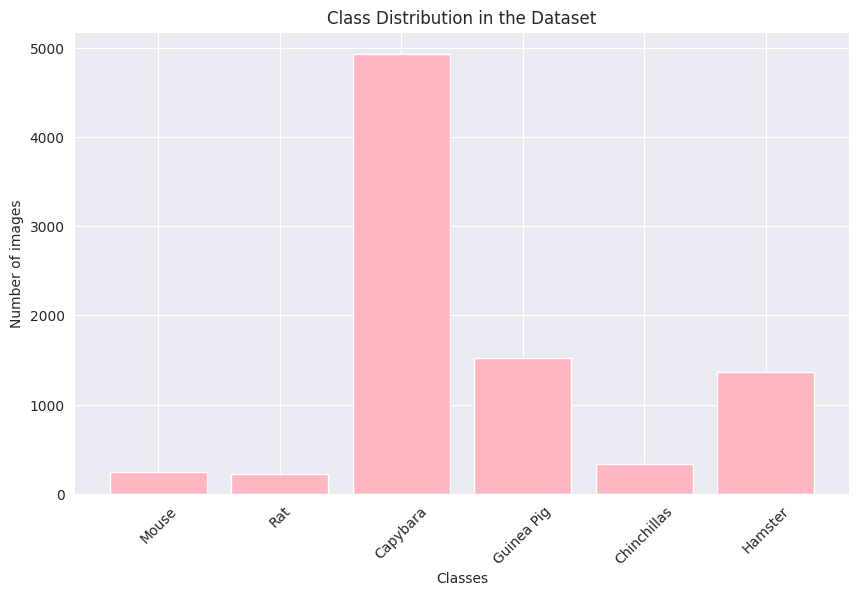

In [ ]:
# Pokazanie na wykresie słupkowym rozkad liczebności klas

data_dir = '/content/Dataset'

# Zliczanie obrazów w każdej klasie
class_counts = {}
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        class_counts[class_name] = len(os.listdir(class_dir))

# Tworzenie wykresu słupkowego
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='lightpink')
plt.xlabel('Classes')
plt.ylabel('Number of images')
plt.title('Class Distribution in the Dataset')
plt.xticks(rotation=45)
plt.show()

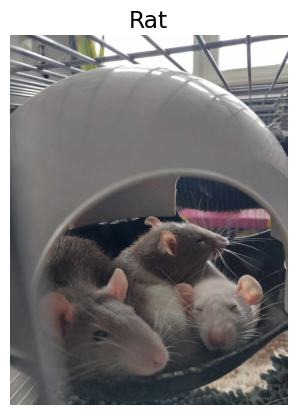

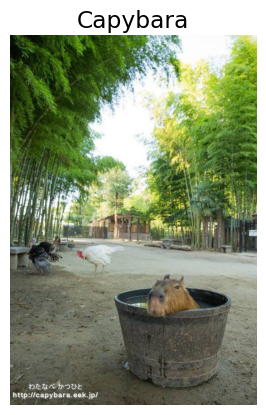

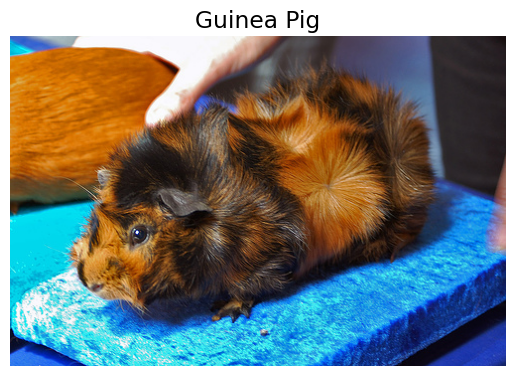

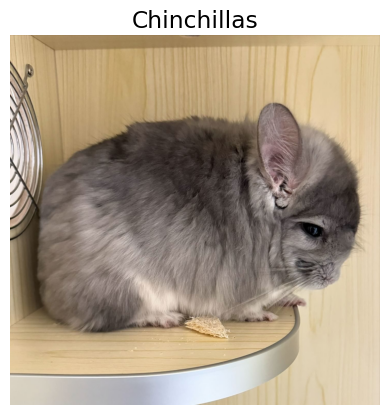

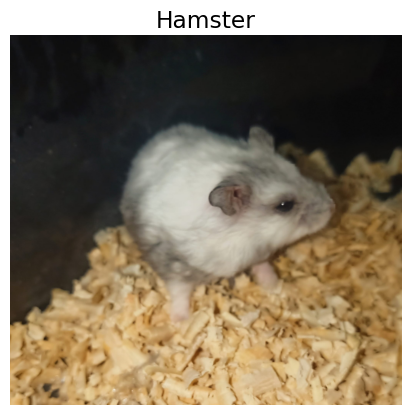

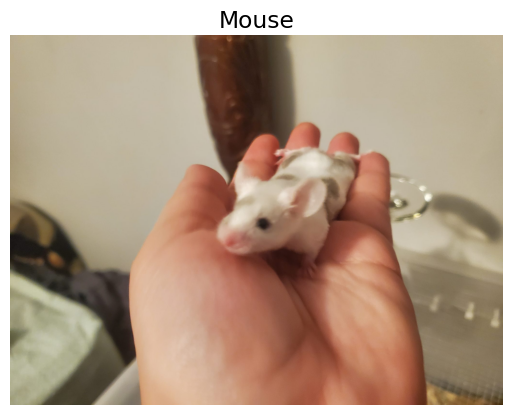

In [ ]:
# Wyświetlenie randomowego obrazu z każdego folderu

data_dir = '/content/Dataset'

# Pobierz listę folderów w głównym katalogu
folders = os.listdir(data_dir)

# Iteruj po każdym folderze i wyświetl losowy obraz
for folder in folders:

    # Utwórz pełną ścieżkę do folderu
    folder_path = os.path.join(data_dir, folder)

    # Pobierz listę plików w folderze
    files = os.listdir(folder_path)

    # Wybierz losowy plik z folderu
    random_file = random.choice(files)

    # Utwórz pełną ścieżkę do losowego pliku
    file_path = os.path.join(folder_path, random_file)

    # Wczytaj obraz i wyświetl go
    image = Image.open(file_path)
    plt.imshow(image)
    plt.title(f"{folder}")
    plt.axis("off")
    plt.show()

# 3. Przygotowanie danych

In [8]:
batch_size = 32
target_size = (224, 224)
dataset = "/content/Dataset"

In [9]:
# Tworzy obiekt Path, dzięki któremu będziemy łatwiej operowali na ścieżkach plików
image_dir = Path(dataset)

# Używa metody glob do wyszukiwania plików o danych rozszerzeniach, wyniki są łączone w jedną listę
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG')) + list(image_dir.glob(r'**/*.JPEG'))

# Dzięki temu dla każdego pliku mamy etykietę, będącą nazwą katalogu
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

# Konwertuje listę na serię Pandas, wszystkie ścieżki są typu String
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Łączy filepaths i labels w jedną ramkę danych Pandas: śieżka pliku i etykieta
image_df = pd.concat([filepaths, labels], axis=1)

In [10]:
# Dzielimy dane: train_df ma 80% oryginalnych danych, test_df ma 20%
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [17]:
# Generator danych dla treningu
train_generator = ImageDataGenerator(
    rescale=1./255,  # Normalizacja pikseli do zakresu [0, 1]
    validation_split=0.2  # Opcjonalnie: wydzielenie części danych treningowych na walidację
)

# Generator danych dla testowania
test_generator = ImageDataGenerator(
    rescale=1./255
)

In [12]:
# Generatory do iteracyjnego ładowania i przetwarzania obrazów w batchach podczas treningu, walidacji i testowania modelu

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=target_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=target_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=target_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 5513 validated image filenames belonging to 6 classes.
Found 1378 validated image filenames belonging to 6 classes.
Found 1723 validated image filenames belonging to 6 classes.


In [ ]:
class_labels = list(test_images.class_indices.keys())
print(class_labels)

['Capybara', 'Chinchillas', 'Guinea Pig', 'Hamster', 'Mouse', 'Rat']


In [ ]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

## 3.1 RUS (Random Under-Sampling)

Polega na losowym usunięciu przykładów z klas większościowych

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Zastosowanie RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

images_resampled, labels_resampled = rus.fit_resample(images, labels)

# Przywrócenie oryginalnego kształtu obrazów
images_resampled = images_resampled.reshape((-1, 224, 224, 3))  # Przywrócenie kształtu do (wysokość, szerokość, kanały)

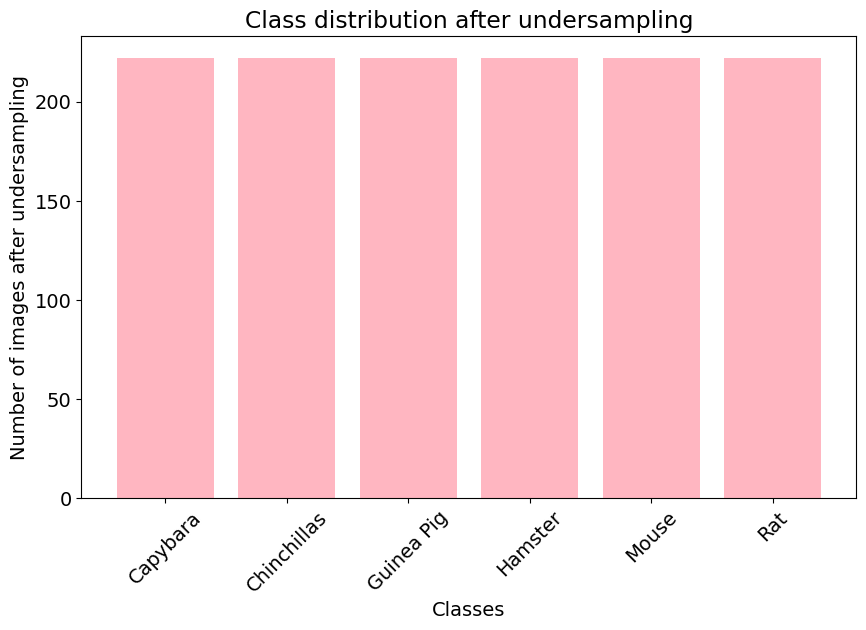

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Liczenie obrazów w każdej klasie po zastosowaniu RandomUnderSampler
unique_labels, counts = np.unique(labels_resampled, return_counts=True)
class_counts_resampled = dict(zip(unique_labels, counts))

# Tworzenie wykresu słupkowego dla zmodyfikowanych danych
plt.figure(figsize=(10, 6))
plt.bar(class_counts_resampled.keys(), class_counts_resampled.values(), color='lightpink')
plt.xlabel('Classes')
plt.ylabel('Number of images after undersampling')
plt.title('Class distribution after undersampling')
plt.xticks(rotation=45)
plt.show()

## 3.2 ROS (Random Over-Sampling)

Polega na losowym duplikowaniu przykładów z klas mniejszościowych

W przypadku OverSamplingu pojawia się problem z niewystarczającym RAM'em w środowisku Google Colab. Zostało zastosowane podejście dzielenia danych na batche, na których jest oddzielnie przeprowadzany oversampling, a następnie łączone są w całość.

In [ ]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np

def batch_iterator(X, y, batch_size=100):
    """Generator, który dzieli dane i etykiety na mniejsze partie."""
    for i in range(0, len(X), batch_size):
        yield X[i:i + batch_size], y[i:i + batch_size]

# Definiowanie strategii oversamplingu
oversample = RandomOverSampler(sampling_strategy='minority')

# Listy do przechowywania przetworzonych danych
images_resampled_list = []
labels_resampled_list = []

# Przetwarzanie danych w partiach
batch_size = 100  # Możesz dostosować rozmiar partii do swoich potrzeb
for images_batch, labels_batch in batch_iterator(images, labels, batch_size=batch_size):
    images_batch_resampled, labels_batch_resampled = oversample.fit_resample(images_batch, labels_batch)
    images_resampled_list.append(images_batch_resampled)
    labels_resampled_list.append(labels_batch_resampled)

# Łączenie wszystkich przetworzonych partii w jeden zbiór danych
images_resampled = np.vstack(images_resampled_list)
labels_resampled = np.concatenate(labels_resampled_list)

# Przywrócenie oryginalnego kształtu obrazów
images_resampled = images_resampled.reshape((-1, target_size[0], target_size[1], 3))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Liczenie obrazów w każdej klasie po zastosowaniu RandomOverSampler
unique_labels, counts = np.unique(labels_resampled, return_counts=True)
class_counts_resampled = dict(zip(unique_labels, counts))

# Tworzenie wykresu słupkowego dla zmodyfikowanych danych
plt.figure(figsize=(10, 6))
plt.bar(class_counts_resampled.keys(), class_counts_resampled.values(), color='lightpink')
plt.xlabel('Classes')
plt.ylabel('Number of images after oversampling')
plt.title('Class distribution after oversampling')
plt.xticks(rotation=45)
plt.show()

NameError: name 'all_labels_resampled' is not defined

## 3.3 SMOTE (Synthetic Minority Over-sampling Technique)

Wybiera próbki z klas mniejszościowych i dla każdej z nich znajduje jej k-najbliższych sąsiadów.

Też wywala RAM.

In [ ]:
from imblearn.over_sampling import SMOTE

# Zastosowanie SMOTE
smote = SMOTE(random_state=42)

# Dla SMOTE obrazy muszą być spłaszczone
images_resampled, labels_resampled = smote.fit_resample(images, labels)

# Przywrócenie oryginalnego kształtu obrazów
target_size = (224, 224)  # Zakładając, że taki jest rozmiar obrazów
images_resampled = images_resampled.reshape((-1, target_size[0], target_size[1], 3))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Liczenie obrazów w każdej klasie po zastosowaniu RandomOverSampler
unique_labels, counts = np.unique(labels_resampled, return_counts=True)
class_counts_resampled = dict(zip(unique_labels, counts))

# Tworzenie wykresu słupkowego dla zmodyfikowanych danych
plt.figure(figsize=(10, 6))
plt.bar(class_counts_resampled.keys(), class_counts_resampled.values(), color='lightpink')
plt.xlabel('Classes')
plt.ylabel('Number of images after SMOTE')
plt.title('Class distribution after SMOTE')
plt.xticks(rotation=45)
plt.show()

## 3.4 Hydrydowo

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle
import numpy as np
from collections import Counter

# Mieszanie danych
# images, labels = shuffle(images, labels)

# Obliczanie średniej liczby próbek na klasę dla undersamplingu
counter = Counter(labels)
average_samples_per_class = int(sum(counter.values()) / len(counter))
undersampling_strategy = {label: min(count, average_samples_per_class) for label, count in counter.items()}

# Definiowanie strategii undersamplingu i oversamplingu
under = RandomUnderSampler(sampling_strategy=undersampling_strategy)
over = RandomOverSampler(sampling_strategy='auto')  # 'auto' oznacza wyrównanie do liczby próbek w najliczniejszej klasie

# Najpierw undersampling
images_under, labels_under = under.fit_resample(images.reshape(-1, target_size[0] * target_size[1] * 3), labels)

# Następnie oversampling
images_over, labels_over = over.fit_resample(images_under, labels_under)

# Przywrócenie oryginalnego kształtu obrazów po undersamplingu i oversamplingu
images_resampled = images_over.reshape(-1, target_size[0], target_size[1], 3)


## 3.5 Użycie wagi klas

In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Obliczanie wag dla każdej klasy
class_weights = class_weight.compute_class_weight(
    'balanced',
    np.unique(train_generator.classes),
    train_generator.classes)

class_weights = dict(enumerate(class_weights))

# potem:

model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    class_weight=class_weights  # Używanie obliczonych wag
)

NameError: name 'train_generator' is not defined

# 4. Augmentacja klas

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Inicjalizacja generatora danych z augmentacją dla danych treningowych
train_datagen = ImageDataGenerator(
    rescale=1./255,   # Normalizacja wartości pikseli
    rotation_range=40,  # Losowe obracanie obrazów w zakresie (w stopniach)
    width_shift_range=0.2,  # Losowe przesunięcia poziome obrazów
    height_shift_range=0.2,  # Losowe przesunięcia pionowe obrazów
    shear_range=0.2,  # Losowe przycinanie obrazów
    zoom_range=0.2,  # Losowe przybliżanie obrazów
    horizontal_flip=True,  # Losowe odbicia lustrzane obrazów
    fill_mode='nearest'  # Strategia wypełniania nowych pikseli, które mogą powstać po augmentacji
)

# Wczytanie danych
train_generator = train_datagen.flow(
    images_resampled,
    labels_resampled,
    batch_size=32,
    target_size=(224, 224)  # Rozmiar docelowy obrazów
)

# 5. Wybranie modelu

## 5.1 VGG16

In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.vgg19.VGG19(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

## 5.2 ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50

# Load pre-trained ResNet50 model
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base
for layer in resnet_model.layers:
    layer.trainable = False

# Create your own classification layers
# For example, adding a GlobalAveragePooling2D layer and a Dense layer for classification
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

x = GlobalAveragePooling2D()(resnet_model.output)
output = Dense(6, activation='softmax')(x)

# Combine the base model with the custom classification layers
model = Model(resnet_model.input, output)

## 5.3 AlexNet

In [ ]:
model=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10,activation='softmax')
])

## 5.4 EfficientNet

In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB7(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

## 5.5 DenseNet

In [ ]:
from tensorflow.keras.applications import DenseNet121

# Load pre-trained DenseNet121 model trained on ImageNet
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base
for layer in densenet_model.layers:
    layer.trainable = False

# Create your own classification layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

x = GlobalAveragePooling2D()(densenet_model.output)
output = Dense(6, activation='softmax')(x)

# Combine the base model with the custom classification layers
model = Model(densenet_model.input, output)


## 5.6 MobileNet

In [ ]:
from tensorflow.keras.applications import MobileNet

# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

# 6. Trenowanie modelu

In [ ]:
# Create checkpoint callback
checkpoint_path = "animals_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [ ]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(6, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "animal_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/animal_classification/20240305-171949
Epoch 1/100
173/173 [==============================] - 3418s 19s/step - loss: 2.1967 - accuracy: 0.3688 - val_loss: 0.7675 - val_accuracy: 0.7554
Epoch 2/100
173/173 [==============================] - ETA: 0s - loss: 1.3170 - accuracy: 0.5677 

KeyboardInterrupt: 

In [ ]:
model.save_weights('animals_eff.h5')

# 7. Ewaluacja modelu

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

## 7.1 Training vs validation accuracy/loss

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

## 7.2 Confusion matrix

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

In [ ]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

In [ ]:
make_confusion_matrix(y_test, pred, list(labels.values()))

## 7.3 Która część jest najważniejsza na zdjęciu?

In [ ]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()

# 8. Ataki adwersarzowe

In [ ]:
# yeah

# 9. Out of Distribution (OOD) Detection

In [ ]:
# yeah